Frankenstein model:
Use two different types of unembedding within the ReLU(x) + x model: 
- Residual path
- MLP

Test different combinations of identity, transpose, pseudoinverse. 

In [1]:
# Set up notebook

"""Import necessary packages"""

%load_ext autoreload
%autoreload 2

import os
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t
import matplotlib.pyplot as plt

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.plot import plot_loss_across_sparsities, plot_input_output_response, plot_phase_diagram_polysem
from toy_cis.plot import plot_weight_bars, plot_phase_diagram, plot_phase_diagram_training
from toy_cis.util import threshold_matrix, in_out_response, performance_across_sparsities

"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 16})

"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA A40'


In [2]:
"""Contains a toy model class that can (possibly) illustrate computation in superposition.

tms-cis, simple-relu, and res-mlp toy models can all be created with the same class, `Cis`.
"""

from dataclasses import dataclass, field
from typing import Callable, List
from tqdm.notebook import tqdm

import numpy as np
import torch as t

from einops import einsum, rearrange, reduce
from jaxtyping import Float
from torch import nn
from torch.nn import functional as F


@dataclass
class CisConfig:
    """Config class for single hidden layer CiS model."""
    name: str # name of the model
    n_instances: int  # number of model instances
    n_feat: int  # number of features (elements) in input vector
    n_hidden: int  # number of hidden units in the model
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])  # layer act funcs
    # Bias terms for hidden and output layers. For a given layer, if None, biases are not learned;
    # if scalar, all biases have the same value; if tensor, each bias has the corresponding 
    # tensor element value.
    b1: float | Float[t.Tensor, "inst hid"] | None = None
    b2: float | Float[t.Tensor, "inst hid"] | None = 0.0
    W1_as_W2T: bool = False  # W2 is learned if False, else W2 = W1.T
    We_and_Wu: bool = False  # if True, use fixed, random orthogonal embed and unembed matrices
    We_dim: int = 1000  # if We_and_Wu, this is the dim of the embedding space
    skip_cnx: bool = False  # if True, skip connection from in to out is added
    


    def __post_init__(self):
        """Ensure attribute values are valid."""
        # Handle `b1` tensor validation
        if isinstance(self.b1, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b1.shape != expected_shape:
                raise ValueError(f"{self.b1.shape=} does not match {expected_shape=}")
        
        # Handle `b2` tensor validation
        if isinstance(self.b2, t.Tensor):
            expected_shape = (self.n_instances, self.n_hidden)
            if self.b2.shape != expected_shape:
                raise ValueError(f"{self.b2.shape=} does not match {expected_shape=}")



class Cis(nn.Module):
    """A generic computation-in-superposition toy model."""
    # Some attribute type hints
    W1: Float[t.Tensor, "inst hid feat"]
    W2: Float[t.Tensor, "inst feat hid"]
    b1: Float[t.Tensor, "inst hid"]
    b2: Float[t.Tensor, "inst feat"]


    def __init__(self, cfg: CisConfig, device: t.device):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg
        self.device = device
        n_feat = cfg.n_feat

        # Embed and Unembed Matrices
        if cfg.We_and_Wu:
            rand_unit_mats = [
                F.normalize(t.randn(cfg.We_dim, cfg.n_feat), dim=0, p=2) for _ in range(cfg.n_instances)
            ]
            self.We = t.stack(rand_unit_mats).to(device)
            self.Wu_T = rearrange(self.We, "inst emb feat -> inst feat emb")
            self.Wu_p = t.linalg.pinv(self.We)
            n_feat = cfg.We_dim

            

        # Model Weights
        self.W1 = t.empty(cfg.n_instances, cfg.n_hidden, n_feat)
        self.W1 = nn.Parameter(nn.init.xavier_normal_(self.W1))
        if cfg.W1_as_W2T:
            self.W2 = self.W1.T
        else:
            self.W2 = t.empty(cfg.n_instances, n_feat, cfg.n_hidden)
            self.W2 = nn.Parameter(nn.init.xavier_normal_(self.W2))

        # Model Biases
        if cfg.b1 is None:
            self.b1 = t.zeros(cfg.n_instances, cfg.n_hidden, device=device)
        elif np.isscalar(cfg.b1):
            self.b1 = nn.Parameter(t.full((cfg.n_instances, cfg.n_hidden), cfg.b1))
        else:
            self.b1 = nn.Parameter(cfg.b1)

        if cfg.b2 is None:
            self.b2 = t.zeros(cfg.n_instances, n_feat, device=device)
        elif np.isscalar(cfg.b2):
            self.b2 = nn.Parameter(t.full((cfg.n_instances, n_feat), cfg.b2))
        else:
            self.b2 = nn.Parameter(cfg.b2)
        
        self.to(device)


    def forward(
        self, 
        x: Float[t.Tensor, "batch inst feat"],
    ) -> Float[t.Tensor, "batch inst feat"]:
        """Runs a forward pass through the model."""
        
        e = None
        # Embedding layer
        if self.cfg.We_and_Wu:
            e = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")
        
        # Hidden layer
        h = einsum(e if e is not None else x, self.W1, "batch inst feat, inst hid feat -> batch inst hid")
        h = self.cfg.act_fn[0](h + self.b1)

        # Output layer
        if self.cfg.We_and_Wu: 
            y1 = einsum(h, self.W2, "batch inst hid, inst emb hid -> batch inst emb")
        else:
            y = einsum(h, self.W2, "batch inst hid, inst feat hid -> batch inst feat")
        y1 = self.cfg.act_fn[1](y1 + self.b2)
        
        # Skip connection
        if self.cfg.skip_cnx:
            if self.cfg.We_and_Wu:
                y2 = einsum(x, self.We, "batch inst feat, inst emb feat -> batch inst emb")
            else:
                y += x
        
        # Unembedding layer
        if self.cfg.We_and_Wu:
            
            y1 = einsum(y1, self.Wu_p, "batch inst emb, inst feat emb -> batch inst feat")
            y2 = einsum(y2, self.Wu_T, "batch inst emb, inst feat emb -> batch inst feat")
            y = y1 + y2
        return y
        
    def gen_batch_reluPlusX (self, batch_sz: int, sparsity: float | Float[t.Tensor, "inst feat"]) -> (
        tuple[Float[t.Tensor, "batch inst feat"], Float[t.Tensor, "batch inst feat"]]
    ):
        """Generates a batch of x, y data."""
        # Randomly generate features vals, and for each, randomly set which samples are non-zero
        x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) * 2 - 1  # [-1, 1]
        is_active = (
            t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat, device=self.device) < (1 - sparsity)
        )
        x *= is_active
        return x, x + t.relu(x)

    def loss_fn_reluPlusX(self, y, y_true, i):
        return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

    def train_reluPlusX(
        self,
        batch_sz: int,
        feat_sparsity: float | Float[t.Tensor, "inst feat"],
        feat_importance: float | Float[t.Tensor, "inst feat"],
        n_steps: int,
        lr: float,
        logging_freq: int,
    ) -> List[Float]:
        """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
        losses = []
        
        optimizer = t.optim.AdamW(self.parameters(), lr=lr, weight_decay=0.01)
        
        pbar = tqdm(range(n_steps), desc="Training")
        for step in pbar:
            x, y_true = self.gen_batch_reluPlusX(batch_sz, feat_sparsity)
            y = self.forward(x)
            loss = self.loss_fn_reluPlusX(y, y_true, feat_importance)
            
            # Update the learning rate
            current_lr = lr * np.cos(0.5 * np.pi * step / (n_steps - 1))
            for param_group in optimizer.param_groups:
                param_group["lr"] = current_lr
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == n_steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})
        
        return losses
# Note:
# Feature sparsity should be used in a function that generates batches.
# Feature importance should be used in a loss function.
# Both of these should be defined outside of this class, and called in a training loop.


In [3]:
"""ReLU + x model with Random embedding"""
layer_act_fns = [t.relu, lambda x: x]

reluPlusX_res_embed_cfg = CisConfig(
    name = "ReluPlusX_WithEmbedding",
    n_instances=1,
    n_feat=100,
    n_hidden=50,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000,
)

In [4]:
# Choose a model to train and explore characteristics
"""Select the model configuration"""
model_cfg = reluPlusX_res_embed_cfg

"""Select the feature probability of the training input."""
feat_sparsity = 0.99

In [5]:
# Train model

"""Training hyperparameters"""
feat_prob = 1 - feat_sparsity
batch_sz = 2048
feat_importance = 1
lr = 3e-3
n_steps = 10000
logging_freq = n_steps // 10

model = Cis(model_cfg, device=device)

losses = model.train_reluPlusX(
        batch_sz,
        feat_sparsity,
        feat_importance,
        n_steps,
        lr, 
        logging_freq, 
)
display(losses)

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

[0.002124687423929572,
 0.0006713178008794785,
 0.000680162978824228,
 0.0006874630344100296,
 0.000644381798338145,
 0.0006701581296510994,
 0.0007064837263897061,
 0.000700416334439069,
 0.0006719581433571875,
 0.0006772681954316795,
 0.0006976884324103594]

X.shape =  torch.Size([100, 100, 100])
Y.shape =  torch.Size([100, 100, 100])


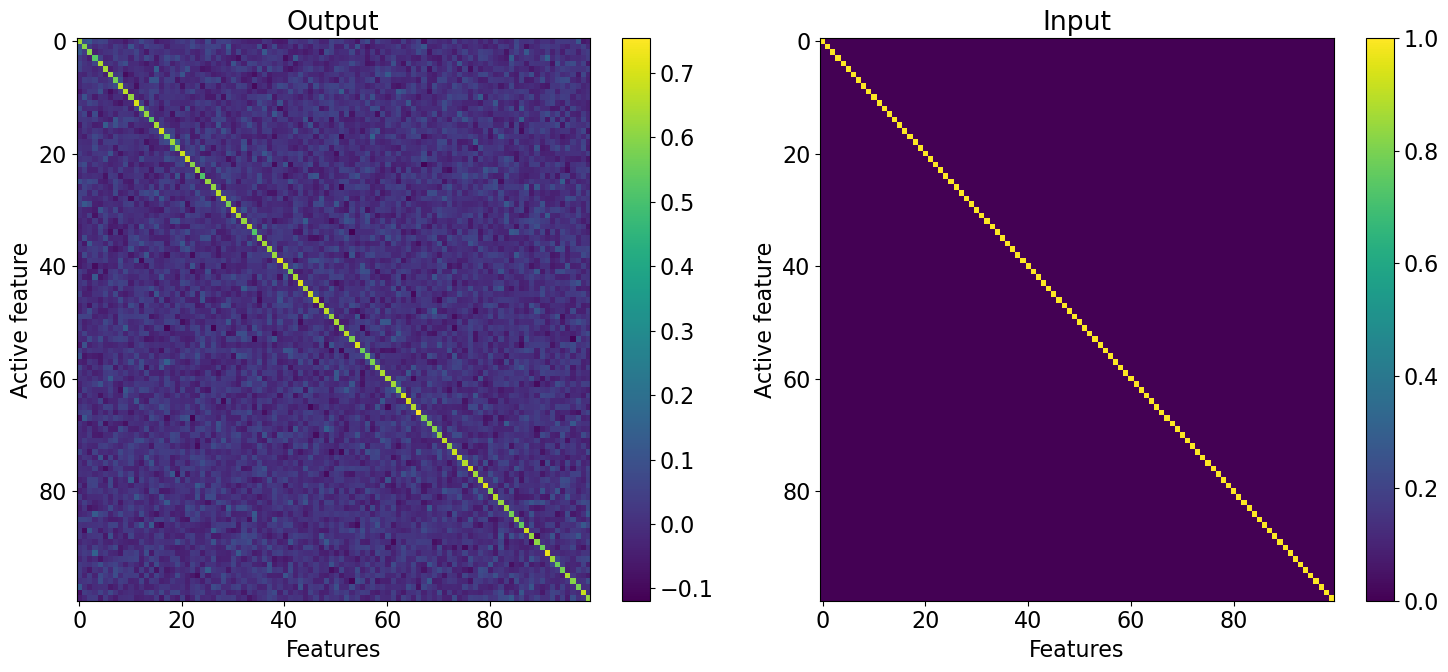

[[ 1.6363676e+00  9.3107611e-02  1.2008978e-01 ...  1.1653096e-01
  -6.4213850e-02 -4.1063964e-02]
 [ 9.3290940e-02  1.5948451e+00  3.0534368e-02 ...  4.6584802e-03
   4.6667919e-02 -1.4730778e-02]
 [ 1.2263257e-01  3.3869740e-02  1.5989635e+00 ... -4.1964278e-02
   1.8229011e-02  3.8297828e-02]
 ...
 [ 1.2070965e-01 -1.3295757e-03 -4.3796875e-02 ...  1.5758389e+00
  -5.5372412e-03 -1.4910875e-03]
 [-7.5362310e-02  4.0900715e-02  2.3553714e-02 ... -1.4496913e-02
   1.6807690e+00  7.5895702e-03]
 [-4.8134856e-02 -1.8517109e-02  2.9880513e-02 ...  9.5235184e-05
   1.8151458e-02  1.6150532e+00]]


In [6]:
"""Plot spectrum output plots"""

vals = t.linspace(-1, 1, 100, device=device)  # input values
active_feat_value_idx = 99

n_feat, n_vals = model.cfg.n_feat, len(vals)
# input `X` will be: active_feature_idx X values X full_feature_vector
X = t.zeros(n_feat, n_vals, n_feat, device=device)
feat_idx = t.arange(n_feat, device=device).unsqueeze(1).expand(n_feat, n_vals)
val_idx = t.arange(n_vals, device=device).unsqueeze(0).expand(n_feat, n_vals)
X[feat_idx, val_idx, feat_idx] = vals.unsqueeze(0).expand(n_feat, n_vals)
# reshape for batch input
X = rearrange(X, "active_feat val feat_vec -> (active_feat val) 1 feat_vec")
Y = model.forward(X)
    # reshape for plotting by feature
Y = rearrange(
   Y, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals
)
X = rearrange(X, 
   "(active_feat val) 1 feat_vec -> active_feat val feat_vec",
    active_feat=n_feat, 
   val=n_vals)
print("X.shape = ", X.shape)
print("Y.shape = ", Y.shape)
output= Y[:,active_feat_value_idx,:].cpu().detach().numpy()
input = X[:,active_feat_value_idx,:].cpu().detach().numpy()

fig,axs = plt.subplots(1, 2, figsize=(15, 7))
im0 = axs[0].imshow(output-input, aspect='auto', cmap='viridis')
fig.colorbar(im0, ax=axs[0])
axs[0].set_title("Output")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Active feature")

im1 = axs[1].imshow(input, aspect='auto', cmap='viridis')
fig.colorbar(im1, ax=axs[1])
axs[1].set_title("Input")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("Active feature")
#fig.title(f"{model.cfg.name} trained at featProb = {feat_prob:.2f}:\n output heatmap")
plt.tight_layout()
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_output_heatmap.png" 
plt.savefig(filename, dpi=300)
plt.show()

print(Y[:,active_feat_value_idx,:].cpu().detach().numpy())

Testing over sparsities:   0%|          | 0/28 [00:00<?, ?it/s]

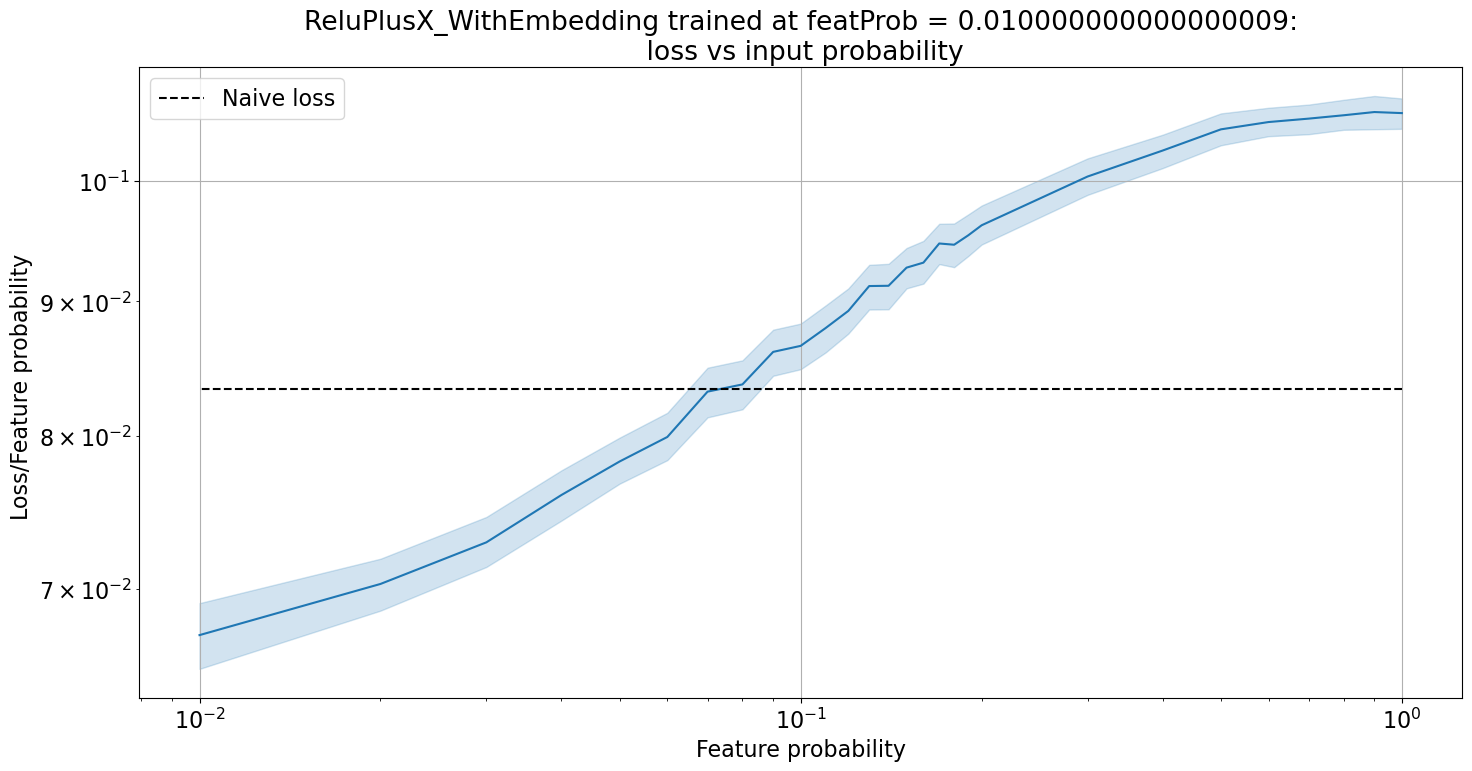

In [7]:
"""Compute and plot the model's performance across sparsities."""

sparsity_low = np.round(np.linspace(0.0,0.8,9),2)
sparsity_high = np.round(np.linspace(0.8,0.99,20),2)
sparsities = np.unique(np.concatenate((sparsity_low,sparsity_high)))
batch_sz = 256
feat_importance = 1

loss_data = performance_across_sparsities(sparsities, model)

"""Plot performance across different input sparsities"""
fig = plot_loss_across_sparsities(loss_data, sparsities, model.cfg.name, feat_sparsity)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_loss_plot.png" 
plt.savefig(filename, dpi=300)
plt.show()

torch.Size([100, 100])


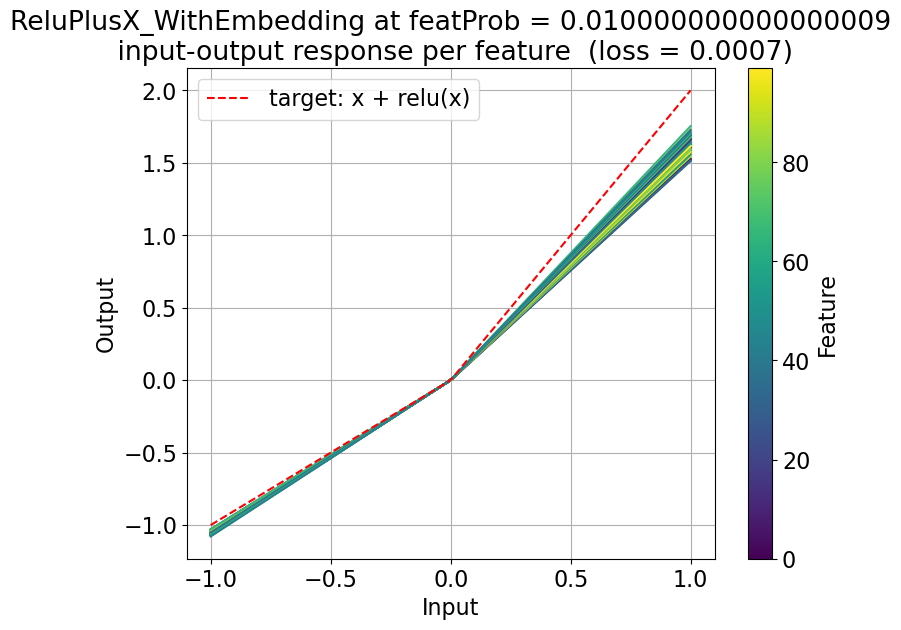

In [8]:
"""Compute and plot input-output response profile."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(model, vals, device)
print(Y.shape)
fig = plot_input_output_response(Y, vals, model.cfg.name, feat_prob, losses)

# save figure and show
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_input_output_response.png" 
plt.savefig(filename, dpi=300)
plt.show()

In [ ]:
"""Extract and plot weights."""

if model.cfg.We_and_Wu == True: 
    W_feat_to_neuron = einsum(model.We, model.W1,
                          "inst emb feat, inst neuron emb -> neuron feat")
    W_neuron_to_feat = einsum(model.W2, model.Wu,
                          "inst emb neuron, inst feat emb -> feat neuron")
    W = einsum(W_feat_to_neuron, W_neuron_to_feat, "neuron feat, feat neuron -> feat neuron")
else:
    W = einsum(model.W1, model.W2, 
               "inst neuron feature, inst feature neuron-> neuron feature")
    
W = threshold_matrix(W.squeeze(), threshold=0.001)

print(f"{W.shape=}")

fig = plot_weight_bars(W.T, xax="feature", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_feature.png" 
plt.savefig(filename, dpi=300)
plt.show

fig = plot_weight_bars(W, xax="neuron", model_name=model.cfg.name, feat_prob=feat_prob)
filename = f"/workspace/{model.cfg.name}_S{feat_prob:.2f}_weights_per_neuron.png" 
plt.savefig(filename, dpi=300)
plt.show